# Hands On Astropy Tutorial - Solutions to the exercises
**Tutors:** Axel Donath and Johannes King

This botebook contains the solutions to the exercises in [astropy_hands_on.ipynb](https://github.com/Asterics2020-Obelics/School2017/blob/master/astropy/astropy_hands_on.ipynb)

## 1. Units and Quantities

- (*easy*) How long does the light travel from the sun to the earth in minutes? How long does the light travel from the Galactic center (assume a distance of 8 kpc) in years? 


In [1]:
from astropy import constants as const
import astropy.units as u

# distance sun - earth
distance_sun = 1 * u.au
# speed of light
speed = const.c
# time
time_sun = distance_sun / speed
print("Light travels from sun to earth in {:.2f}".format(time_sun.to('min')))

# distance to GC
distance_gc = 8 * u.kpc
# time
time_gc = distance_gc / speed
print("Light travels from the GC to earth in {:.2f}".format(time_gc.to('yr')))

Light travels from sun to earth in 8.32 min
Light travels from the GC to earth in 26092.51 yr


- (*advanced*) Define a new unit called `"baro-meter"`, which is eqivalent to 25 cm and use it to measure the height of the empire state building (for other ways to measure the height of a building using a barometer see [barometer question on Wikipedia](https://en.wikipedia.org/wiki/Barometer_question)...)

In [2]:
# define new unit baro-meter
bm = u.def_unit('baro-meter')

# define equivalency
baro_meter = [
   (bm, u.cm, lambda x: 25 * x, lambda x: x / 25)
]

# height of the empire state building
height = 381 * u.m

# convert to baro-meters
height_bm = height.to(bm, equivalencies=baro_meter)
print("The height of the empire state building in baro-meters is {}".format(height_bm))

The height of the empire state building in baro-meters is 1524.0 baro-meter


- (*expert*) Define a function ``powerlaw`` that implements the [well-known power law formula](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/source_models.html#PowerLaw) and accepts quantities as input for the parameters. Calculate the Flux at 1 TeV using ``N_0=2-11 cm-2 s-1 TeV-1, E_0=100 GeV, Gamma=-2``. Now try to integrate it using [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html). I won't work. Thus, define a function ``powerlaw_integrate`` that accepts quantity input and calls [scipy.integrate.quad]() under the hood to perform the integration. Calculate the integral between ``100 GeV`` and ``10 TeV`` using the same values for the power law parameters as above.

In [3]:
# define energies
energy = 1 * u.TeV
energy_lo = 100 * u.GeV
energy_hi = 10 * u.TeV

# define power-law
def powerlaw(energy, index, amplitude, reference):
    return amplitude * (energy/reference) ** -index

# evaluate
flux = powerlaw(energy=energy, index=2, amplitude=2e-11 * u.Unit('cm-2 s-1 TeV-1'), reference=100*u.GeV)
print("Flux @ {}: {:.2g}".format(energy, flux.to('TeV-1 cm-2 s-1')))

# integrate
from scipy.integrate import quad

# direct integration does not work
try:
    integral = quad(func = powerlaw,
                    a = 100 * u.GeV,
                    b = 10 * u.TeV,
                    args = (2, 2e-11 * u.Unit('cm-2 s-1 TeV-1'), 100 * u.GeV),
                   )
except:
    pass

# define custom function (optional: quantity_input decorator forces quantity inpuy)
@u.quantity_input(energy_low=u.TeV,
                  energy_hi=u.TeV,
                  amplitude=u.Unit('cm-2 s-1 TeV-1'),
                  reference=u.Unit('TeV'))
def powerlaw_integrate(energy_low, energy_hi, index, amplitude, reference):
    # Convert to fixed set of units
    emin = energy_low.to('TeV').value
    emax = energy_hi.to('TeV').value
    ampl = amplitude.to('cm-2 s-1 TeV-1').value
    ref = reference.to('TeV').value
    # Allow float input for the index
    idx = u.Quantity(index).value
    
    # Calculate integral
    integral = quad(powerlaw,
                   a=emin,
                   b=emax,
                   args=(idx, ampl, ref))
    
    # Reattach unit
    return integral[0] * u.Unit('cm-2 s-1')

# evaluate it
integral = powerlaw_integrate(energy_low=energy_lo,
                              energy_hi=energy_hi,
                              index=2,
                              amplitude=2e-11 * u.Unit('cm-2 s-1 TeV-1'),
                             reference=100 * u.GeV)

print("Integral between {:.2f} and {:.2f}: {:.2g}".format(energy_lo, energy_hi, integral))

Flux @ 1.0 TeV: 2e-13 1 / (cm2 s TeV)
Integral between 100.00 GeV and 10.00 TeV: 2e-12 1 / (cm2 s)


## 2. Coordinates

- (*easy*) Define the sky coordinate for your favorite object and find the distance to the crab nebula and Galactic center.

In [4]:
from astropy.coordinates import SkyCoord

# Coordinate of PKS2155-305
coord_pks = SkyCoord.from_name('pks2155-304')

# Coordinate of the Crab Nebula
coord_crab = SkyCoord.from_name('crab')
separation_crab = coord_pks.separation(coord_crab)
print('The angular distance between PKS2155-204 and the Crab Nebula is {:.2f}'.format(separation_crab))

# Coordinate of the Galactic Center
coord_gc = SkyCoord(0, 0, unit='deg', frame='galactic')
separation_gc = coord_pks.separation(coord_gc)
print('The angular distance between the GC and the Crab Nebula is {:.2f}'.format(separation_gc))

The angular distance between PKS2155-204 and the Crab Nebula is 120.89 deg
The angular distance between the GC and the Crab Nebula is 54.32 deg


- (*advanced*) ?? 

- (*expert*) Make a plot of the height above horizon vs.time for the crab position at the location of Annecy. Mark the the time range where it is visible.

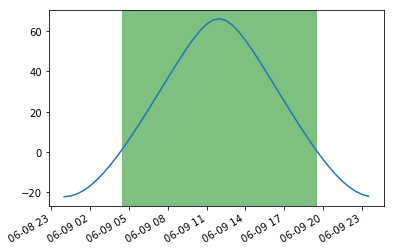

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time
import numpy as np
from astropy.visualization import quantity_support

# Define coordinate
coord_crab = SkyCoord.from_name('crab')

# Set location
annecy = EarthLocation(lat=45.8058 * u.deg, lon=6.5726 * u.deg)

# Define array of times (30 minute intervals)
tstep = 30 * u.min
tend = 1 * u.day
time_start = Time('2017-06-09 00:00:00')
times = Time(time_start + np.arange(0, tend.to('min').value, tstep.to('min').value) * u.min)

# Get AltAz coordinates
altaz = AltAz(obstime=times, location=annecy)
crab_altaz = coord_crab.transform_to(altaz)

# Get altitude over horizon
altitudes = crab_altaz.alt.to('deg')

# Get times when altitude > 0
idx = np.where(altitudes > 0 * u.deg)[0]
tmin, tmax = times[idx[[0, -1]]]

with quantity_support():
    plt.plot_date(times.plot_date, altitudes, fmt='-')
    # orient date labels at a slant
    plt.gcf().autofmt_xdate() 
    # fancy way to use fill_between, see https://matplotlib.org/examples/pylab_examples/fill_between_demo.html
    import matplotlib.transforms as mtransforms
    trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
    plt.fill_between(times.plot_date,
                     0, 1,
                     where=altitudes > 0,
                     facecolor='green',
                     alpha=0.5,
                     transform=trans)

## 3. Tables

- (*easy*) Add columns with the `RA` and `DEC` coordinates of the objects to the example table.

- (*advanced*) Load the example table `fermi_2fhl.fits`. Find all sources within 1 deg from the crab.

- (*expert*) Load the table `fermi_2fhl.fits` and make an all sky plot of the source positions.

## 4. FITS Images and WCS

- (*easy*) 

- (*advanced*) Sum up all the data within a circle of X deg around the position of. You can use [np.indices()]() you can get arrays of x and y pixel positions 
    

- (*hard*) Find the sky position of the brightest pixel in the data. You can use e.g. [np.argmax()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html).

## 5. Plotting of sky images (optional)

- (*easy*)

- (*advanced*) Make a combined RGB image of the Chandra data in different energy bands. You can use e.g. [make_lupton_rgb](http://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html#astropy.visualization.make_lupton_rgb)

- (*expert*) 

## Acknowledgements
![](asterics_log.png)

This tutorial was supported by the H2020-Astronomy ESFRI and Research Infrastructure Cluster (Grant Agreement number: 653477).